# Import Data and Libraries

In [10]:
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

import cdsapi
import sklearn_pandas as skp

custom_colors = ['68A33E', '#A10702', '#FB9E60', '#FFFF82', '#0F0326']

# Load in Raw Data

In [11]:
##################################################
##### 1. Loading raw data #####
input_filename = './Data/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
        NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID,
        NWCG_REPORTING_UNIT_NAME,
        FIRE_NAME,
        COMPLEX_NAME,
        FIRE_YEAR,
        DISCOVERY_DATE,
        DISCOVERY_DOY,
        DISCOVERY_TIME,
        CONT_DATE,
        CONT_DOY,
        CONT_TIME,
        FIRE_SIZE,
        FIRE_SIZE_CLASS,
        OWNER_CODE,
        OWNER_DESCR,
        LATITUDE,
        LONGITUDE,
        STATE,
        COUNTY
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 20 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   NWCG_REPORTING_AGENCY     object 
 1   NWCG_REPORTING_UNIT_ID    object 
 2   NWCG_REPORTING_UNIT_NAME  object 
 3   FIRE_NAME                 object 
 4   COMPLEX_NAME              object 
 5   FIRE_YEAR                 int64  
 6   DISCOVERY_DATE            float64
 7   DISCOVERY_DOY             int64  
 8   DISCOVERY_TIME            object 
 9   CONT_DATE                 float64
 10  CONT_DOY                  float64
 11  CONT_TIME                 object 
 12  FIRE_SIZE                 float64
 13  FIRE_SIZE_CLASS           object 
 14  OWNER_CODE                float64
 15  OWNER_DESCR               object 
 16  LATITUDE                  float64
 17  LONGITUDE                 float64
 18  STATE                     object 
 19  COUNTY                    object 
dtypes: float64(7), int64(2),

In [12]:
input_filename = './Data/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
       *
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

# Clean Data and Extract Oregon Boundaries

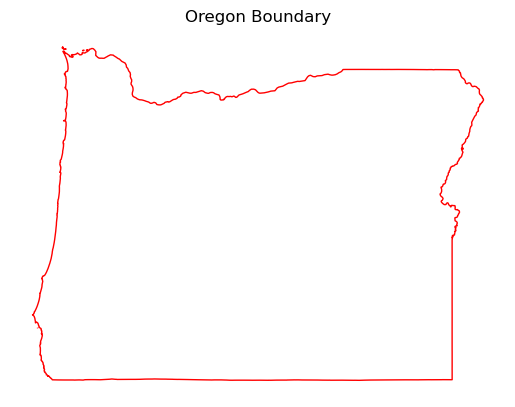

In [13]:
##################################################
##### 2. Cleaning data and extracting Oregon #####
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME', 
                'OWNER_DESCR',
                'FIRE_SIZE_CLASS',
                'OWNER_CODE']
df_OR = df_raw[df_raw.STATE == 'OR'].drop(columns=drop_columns)
#Extracting onset month and day
df_OR['MONTH'] = df_OR['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_OR['DAY'] = df_OR['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])
df_OR.head(2)

us_states = gpd.read_file("./Data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
oregon = us_states[us_states['NAME'] == 'Oregon']
oregon.plot(ax=plt.gca(), color='white', edgecolor='red')
plt.title("Oregon Boundary")
plt.axis('off')
plt.show()

# Monthly/Seasonaly fire frequency

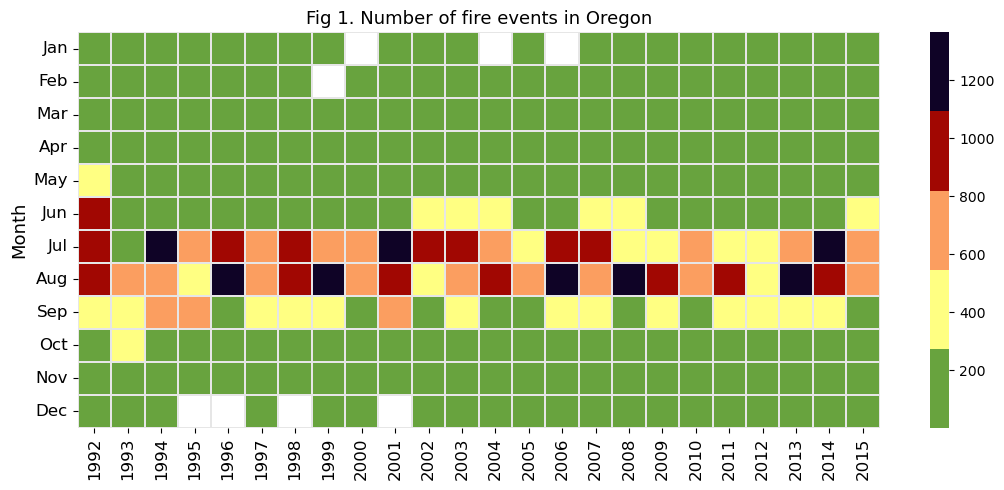

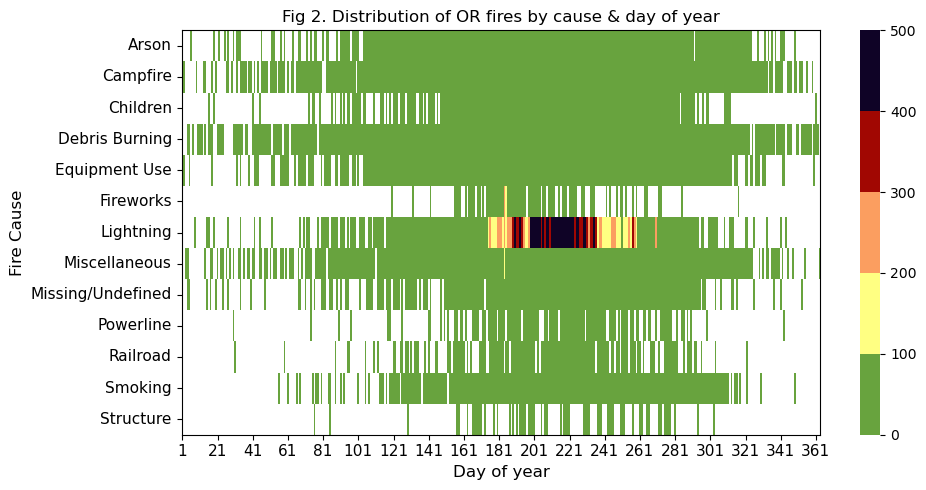

In [14]:
custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors

##################################################
##### 3. Monthly/seasonal fire frequency #####

df_freq_mon = df_OR.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
df_freq_mon.to_csv("wildfireData.csv")
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in Oregon', fontsize=13)
plt.tight_layout()

# plot fire frequency by cause and day of year
cause_by_doy = df_OR.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of OR fires by cause & day of year')
plt.tight_layout()


# Download and Extract Climate Data (ERAS)

In [12]:
import os

# Get the user directory within the current environment
env_name = 'musa-550-fall-2023'
env_user_dir = os.path.join(os.environ['CONDA_PREFIX'], 'envs', env_name)

print(f"User directory in {env_name} environment: {env_user_dir}")

User directory in musa-550-fall-2023 environment: C:\Users\kathl\mambaforge\envs\musa-550-fall-2023\envs\musa-550-fall-2023


# Assessing climate trends

In [8]:
## CONVERT TIME STAMPS INTO COLUMNS
import pandas as pd
bendWeather = pd.read_csv("./Data/BendWeather.csv")
# Function to handle different date formats
def convert_date(date_str):
    formats_to_try = ['%d/%m/%Y %H:%M', '%m/%d/%Y %H:%M']  # Add more formats if needed
    for fmt in formats_to_try:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return None  # If none of the formats match

# Apply the function to the 'interval60' column
bendWeather['interval60'] = bendWeather['interval60'].apply(convert_date)

# Extract day, month, year, and hour into separate columns
bendWeather['Day'] = bendWeather['interval60'].dt.day
bendWeather['Month'] = bendWeather['interval60'].dt.month
bendWeather['Year'] = bendWeather['interval60'].dt.year
bendWeather['Hour'] = bendWeather['interval60'].dt.hour

# Display the updated DataFrame with new columns
print(bendWeather.head(3))



           interval60  Temperature  Precipitation  Wind_Speed  Dew_Point_Temp  \
0 2020-01-01 00:00:00         46.4           0.02          15            41.0   
1 2020-01-01 01:00:00         44.6           0.01          14            41.0   
2 2020-01-01 02:00:00         44.6           0.01          18            41.0   

   Day  Month  Year  Hour  
0    1      1  2020     0  
1    1      1  2020     1  
2    1      1  2020     2  


# Analyzing Weather Patterns

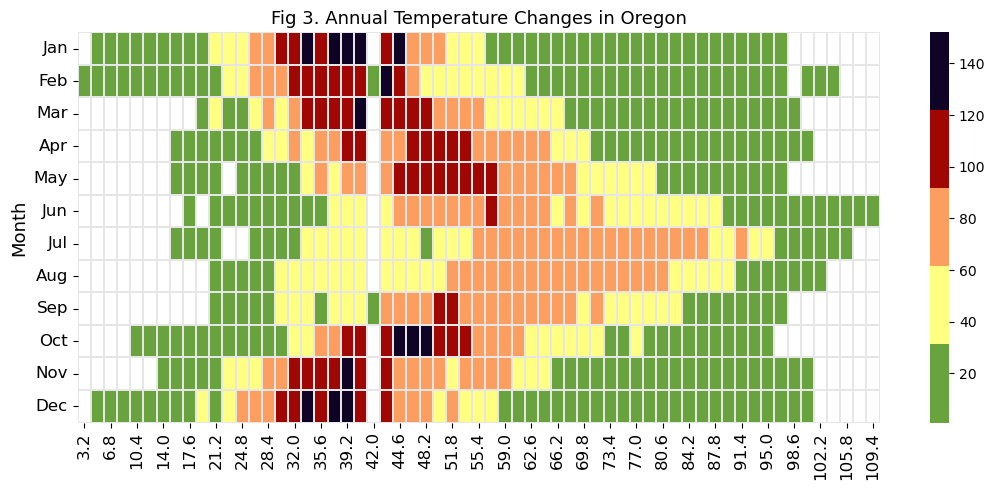

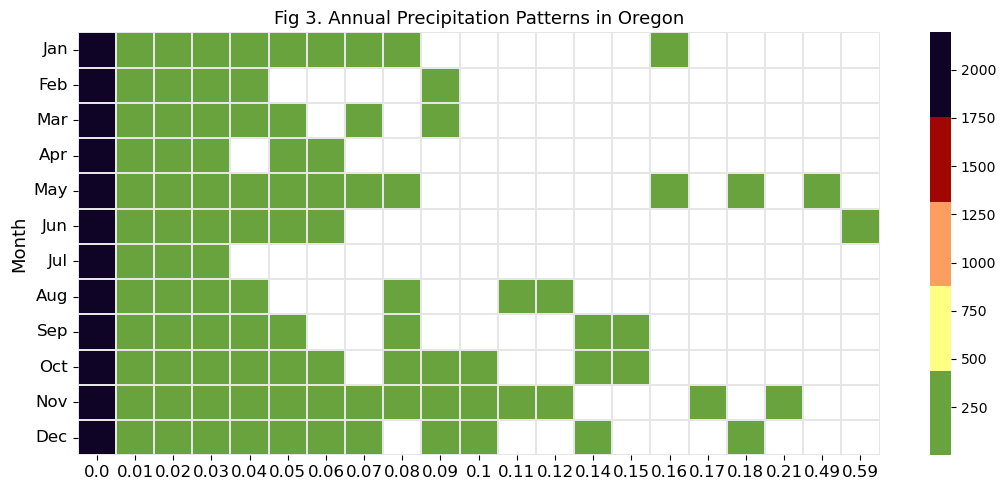

In [17]:
# Annual Temperature
df_freq_mon = bendWeather.groupby(['Month', 'Temperature']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Annual Temperature Changes in Oregon', fontsize=13)
plt.tight_layout()

# Patterns in Wind Speed

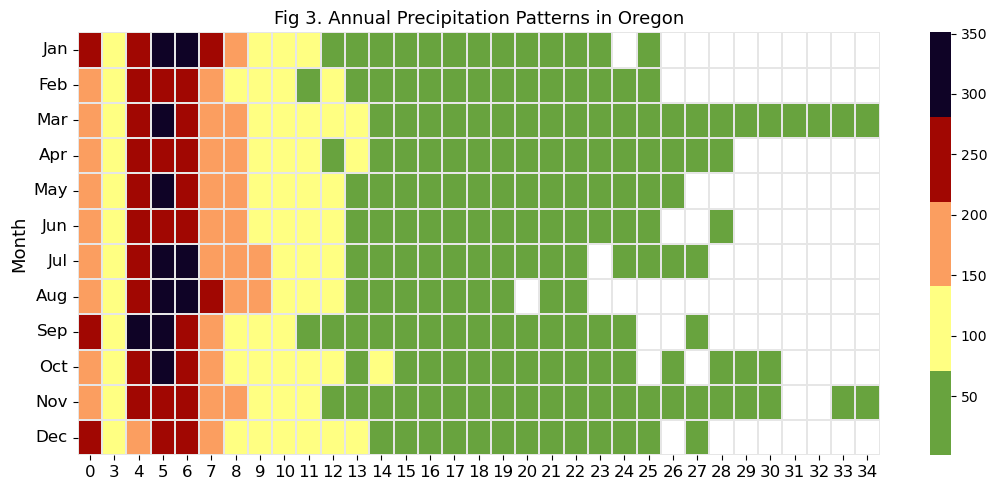

In [21]:
# Annual Patterns in Wind Speed
df_freq_mon = bendWeather.groupby(['Month', 'Wind_Speed']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Annual Precipitation Patterns in Oregon', fontsize=13)
plt.tight_layout()
#plt.savefig(f'../Figures/Fig{counter_fig}.png', format='png', dpi=200)

